# Projet Data Science Livrable 2


GROUPE : 
- Ali RAMDANI
- Nariman FOUGHALI
- Meriem HAMOUMA
- Aissa HADJ ARAB


Ce livrable nous a permis d'entraîné un modèle de débruitage d'images basé sur une architecture de réseau de neurones convolutionnel. 
nous utilisons des générateurs de données pour entraîner et évaluer le modèle sur des données bruyantes et débruitées. 

Le modèle a été entraîné à prédire des images débruitées à partir d'images bruyantes et a été évalué sur un ensemble de données de validation. 

Enfin, des fonctions ont été définies pour prédire des images débruitées à partir de données bruyantes provenant de générateurs de données ou de fichiers sur le disque.

Ce code importe différentes bibliothèques et modules qui seront utilisés dans le programme.

- zipfile est une bibliothèque Python qui permet de travailler avec des fichiers au format zip.
- tensorflow est une bibliothèque de machine learning et de deep learning populaire qui fournit une variété d'outils pour entraîner et utiliser des modèles de machine learning.
- keras est une bibliothèque de haut niveau qui facilite l'utilisation de tensorflow pour l'entraînement et l'utilisation de modèles de deep learning.

- matplotlib est une bibliothèque de visualisation de données qui permet de tracer des graphiques et des figures.
- numpy est une bibliothèque qui fournit des fonctionnalités de calcul scientifique, notamment des outils pour travailler avec des tableaux de nombres à une ou plusieurs dimensions.
- skimage est une bibliothèque qui fournit des fonctionnalités pour travailler avec des images numériques, comme charger, afficher et modifier des images.

- os est une bibliothèque qui fournit un accès aux fonctionnalités du système d'exploitation, comme la gestion des fichiers et des dossiers.
- sys est une bibliothèque qui fournit un accès aux fonctionnalités du système, comme les arguments de la ligne de commande et la gestion des erreurs.
- shutil est une bibliothèque qui fournit des outils pour manipuler des fichiers et des dossiers, comme copier, déplacer et supprimer.
- tempfile est une bibliothèque qui fournit des outils pour travailler avec des fichiers temporaires.
- datetime est une bibliothèque qui fournit des outils pour travailler avec les dates et les heures.
- random est une bibliothèque qui fournit des outils pour générer des nombres aléatoires.

In [700]:
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout , Conv2DTranspose
from tensorflow.keras import Model, Input, regularizers

import matplotlib.pyplot as plt
import numpy as np
import skimage

import os , sys , shutil , tempfile , datetime , random

Cette ligne de code imprime la version de tensorflow qui est actuellement utilisée. 

In [701]:
# Use Python version : 3.8.8
# Use Tensorflow version : < 2.11.0
print("Tensorflow version : ", tf.__version__)

Tensorflow version :  2.10.1


Cette fonction vérifie si le matériel GPU (Graphics Processing Unit, ou Unité de Traitement Graphique en français) est disponible et configurable pour être utilisé par tensorflow. Si un GPU est disponible, la fonction imprime un message indiquant que le GPU est disponible et affiche une liste des dispositifs GPU physiques disponibles. Elle essaie également de configurer ces dispositifs GPU pour permettre à leur mémoire de croître au besoin. Si aucun GPU n'est disponible, la fonction imprime un message indiquant que le GPU n'est pas disponible et affiche une liste de tous les dispositifs matériels disponibles.

La fonction list_physical_devices de tf.config.experimental renvoie une liste de dispositifs matériels disponibles du type spécifié (par exemple, 'GPU' pour les dispositifs GPU). La fonction set_memory_growth de tf.config.experimental permet de configurer le dispositif spécifié pour permettre à sa mémoire de croître au besoin au lieu de l'allouer en totalité au démarrage. Cela peut être utile pour éviter de gaspiller de la mémoire lorsque le modèle n'en a pas besoin et pour éviter de manquer de mémoire lorsque le modèle en a besoin.

In [702]:
def prepare_gpu_acceleration():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print("GPU is AVAILABLE 🚀")
        print(tf.config.experimental.list_physical_devices('GPU'))
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print("An error occured while setting memory growth for GPU 💀")
            print(e)
    else:
        print("GPU is NOT AVAILABLE 🐌")
        print(tf.config.experimental.list_physical_devices())

prepare_gpu_acceleration()

GPU is AVAILABLE 🚀
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Ce code définit plusieurs constantes qui seront utilisées dans le programme.

- IMG_W et IMG_H définissent la largeur et la hauteur des images en pixels.
- RESCALING_FACTOR est un facteur de rééchantillonnage utilisé pour normaliser les valeurs de pixel des images.
- ROTAION_RANGE est l'intervalle de rotation autorisé en degrés pour les augmentations d'images.
- WIDTH_SHIFT_RANGE et HEIGHT_SHIFT_RANGE sont les intervalle de décalage autorisés en pourcentage de la largeur et de la hauteur des images pour les augmentations d'images.
- SHEAR_RANGE est l'intervalle de torsion autorisé pour les augmentations d'images.
- ZOOM_RANGE est l'intervalle de zoom autorisé pour les augmentations d'images.
- HORIZONTAL_FLIP indique si les images peuvent être retournées horizontalement pour les augmentations d'images.
- VALIDATION_SPLIT est le pourcentage de données qui seront utilisées pour la validation lors de l'entraînement du modèle.
- BATCH_SIZE est la taille du lot utilisée lors de l'entraînement du modèle.
- SEED est une valeur utilisée pour initialiser le générateur de nombres aléatoires.
- EPOCHS est le nombre d'époques d'entraînement à effectuer lors de l'entraînement du modèle.
- LEARING_RATE est le taux d'apprentissage utilisé lors de l'entraînement du modèle.
- STEPS_PER_EPOCH est le nombre de lots d'entraînement à utiliser lors de chaque époque d'entraînement.
- VALIDATION_STEPS est le nombre de lots de validation à utiliser lors de chaque époque d'entraînement.

In [703]:
IMG_W = 128
IMG_H = 128
RESCALING_FACTOR = 1./255
ROTAION_RANGE = 20 
WIDTH_SHIFT_RANGE = 0.2
HEIGHT_SHIFT_RANGE = 0.2 
SHEAR_RANGE = 0.2 
ZOOM_RANGE = 0.2 
HORIZONTAL_FLIP = True 
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
SEED = 42
EPOCHS = 50
LEARING_RATE=0.001
STEPS_PER_EPOCH=250
VALIDATION_STEPS=62

Ce code définit deux variables data_dir et test_dir qui contiennent le chemin des dossiers où se trouvent les données d'entraînement et de test respectivement.

Il crée également un générateur d'images datagen en utilisant la classe ImageDataGenerator de keras.preprocessing.image. Ce générateur permet de générer des données d'entraînement à partir d'un jeu de données d'images en utilisant des augmentations d'images. Les augmentations d'images consistent en des modifications aléatoires apportées aux images d'origine afin de créer de nouvelles images qui seront utilisées pour entraîner le modèle. Les augmentations d'images peuvent inclure des rotations, des décalages, des torsions, des zooms et des retournements.

Le générateur datagen est configuré avec plusieurs arguments qui contrôlent les augmentations d'images qui seront appliquées aux données d'entraînement.

In [704]:
data_dir = "data"
test_dir = "test"
# creer les générateurs d'images
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=RESCALING_FACTOR, 
    rotation_range=ROTAION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE, 
    height_shift_range=HEIGHT_SHIFT_RANGE,
    shear_range=SHEAR_RANGE, 
    zoom_range=ZOOM_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    validation_split=VALIDATION_SPLIT # 80% training and 20% validation
)


Ce code crée trois générateurs d'images: train_generator, validation_generator et test_generator.

- Le générateur train_generator est créé en utilisant la méthode flow_from_directory de datagen. 
Cette méthode permet de générer des données d'entraînement à partir d'un jeu de données d'images en lisant les images d'un dossier et en appliquant les augmentations d'images définies précédemment. data_dir est le chemin du dossier où se trouvent les images d'entraînement,target_size est la taille cible des images en pixels, batch_size est la taille du lot, class_mode indique comment les étiquettes de classe doivent être générées (ici, 'input' indique qu'aucune étiquette n'est générée), subset spécifie le sous-ensemble des données à utiliser (ici, 'training' indique que le générateur doit utiliser les données d'entraînement), et seed est une valeur utilisée pour initialiser le générateur de nombres aléatoires.

- Le générateur validation_generator est créé de la même manière que train_generator, mais en utilisant le sous-ensemble des données de validation (spécifié par subset='validation').

- Le générateur test_generator est créé de la même manière que train_generator et validation_generator, mais en utilisant le dossier de test (spécifié par test_dir) au lieu du dossier d'entraînement et en ne spécifiant aucun sous-ensemble de données (puisque toutes les données du dossier de test doivent être utilisées).

In [705]:
train_generator = datagen.flow_from_directory(
    data_dir ,
    classes=['Photo'],
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='input',
    subset='training', 
    seed=SEED
)

validation_generator = datagen.flow_from_directory(
    data_dir ,
    classes=['Photo'],
    target_size=(IMG_H,IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='input',
    subset='validation',
    seed=SEED
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='input',
    seed=SEED
)


Found 7995 images belonging to 1 classes.
Found 1998 images belonging to 1 classes.
Found 148 images belonging to 1 classes.


Cette fonction prend un générateur d'images dataset en entrée et renvoie un générateur d'images qui produit des images bruitées à partir de celles de dataset.

Le générateur renvoyé par la fonction utilise une boucle for pour parcourir les images et les étiquettes du générateur d'images d'origine. Pour chaque image, il utilise la fonction random_noise de skimage.util pour ajouter différents types de bruit à l'image: bruit gaussien, bruit "sel et poivre", bruit de Poisson et bruit "speckle". Ensuite, il renvoie l'image bruitée et son étiquette à l'aide de l'instruction yield.

Le générateur renvoyé par la fonction peut être utilisé comme n'importe quel autre générateur d'images, en utilisant les méthodes next ou for pour parcourir les images et les étiquettes produites par le générateur.

In [706]:
# def gaussian_noise(img):
#     return skimage.util.random_noise(
#         img,
#         mode='gaussian',
#         var=random.uniform(0.5, 0.9)
#     )


# def salt_noise(img):
#     return skimage.util.random_noise(
#         img,
#         mode='salt',
#         amount=random.uniform(0.2, 0.8)
#     )


# def pepper_noise(img):
#     return skimage.util.random_noise(
#         img,
#         mode='pepper',
#         amount=random.uniform(0.2, 0.8)

#     )


# def s_p_noise(img):
#     return skimage.util.random_noise(
#         img,
#         mode='s&p',
#         amount=random.uniform(0.2, 0.8),
#         salt_vs_pepper=0.5
#     )


# def speckle_noise(img):
#     return skimage.util.random_noise(
#         img,
#         mode='speckle',
#         var=random.uniform(0.5, 0.9)
#     )


# NOISE_FUNCTIONS = [
#     gaussian_noise,
#     salt_noise,
#     pepper_noise,
#     s_p_noise,
#     speckle_noise
# ]


# def make_noise(dataset):
#     for img, label in dataset:
#         noise_function = random.choice(NOISE_FUNCTIONS)
#         noisy_img = noise_function(img)
#         yield (noisy_img, label)

noise_factor = 0.2

def add_noise(image):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1.0, dtype=tf.float32)
    noisy_image = image + noise_factor * noise
    noisy_image = tf.clip_by_value(noisy_image, clip_value_min=0.0, clip_value_max=1.0)
    return noisy_image


Ce code applique la fonction make_noise aux générateurs d'images train_generator, validation_generator et test_generator et affecte les générateurs de bruit produits à ces variables.

Après l'exécution de ces lignes de code, les générateurs train_generator, validation_generator et test_generator produiront des images bruitées au lieu des images d'origine lorsqu'ils seront parcourus. Ces images bruitées peuvent être utilisées pour entraîner un modèle afin qu'il soit capable de "débruiter" des images similaires lors de sa phase de prédiction.

In [707]:
# train_generator = make_noise(train_generator)
# validation_generator = make_noise(validation_generator)

# use the add_noise function to add noise to the images in train and validation set
train_generator = train_generator.map(lambda x, y: (add_noise(x), y))
validation_generator = validation_generator.map(lambda x, y: (add_noise(x), y))

Ces deux fonctions permettent d'afficher des images.

La fonction show_images prend un tableau d'images images en entrée et affiche ces images à l'aide de la bibliothèque matplotlib. Elle prend également un argument facultatif n qui spécifie le nombre d'images à afficher (par défaut, n=10). La fonction crée une figure et ajoute un sous-tracé pour chaque image. Elle utilise la fonction imshow de matplotlib pour afficher chaque image et masque les axes de la figure pour enlever les étiquettes. Enfin, elle affiche la figure à l'aide de la fonction show.

La fonction show_noisy_images prend un générateur d'images dataset en entrée et affiche des images bruitées produites par ce générateur ainsi que les images d'origine correspondantes. Elle utilise la fonction next pour récupérer une image bruitée et son étiquette à partir du générateur, puis appelle la fonction show_images avec l'étiquette et l'image bruitée en tant qu'arguments pour afficher les images.

In [708]:
def show_images(images, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def show_noisy_images(dataset , n=20):
    noisy_img , img = next(dataset)
    show_images(img , n)
    show_images(noisy_img , n)

Ce code appelle la fonction show_noisy_images avec les générateurs train_generator, validation_generator et test_generator en tant qu'arguments, ce qui affiche des images bruitées et les images d'origine correspondantes pour chaque ensemble de données.

Avant d'appeler chaque fonction, le code imprime également un message indiquant quel ensemble de données est en train d'être affiché.

Train set


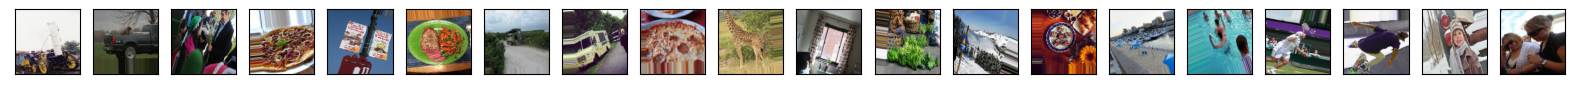

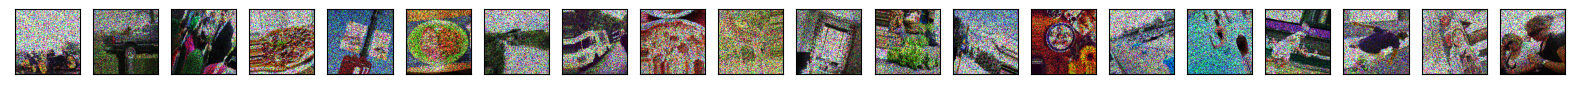

Validation set


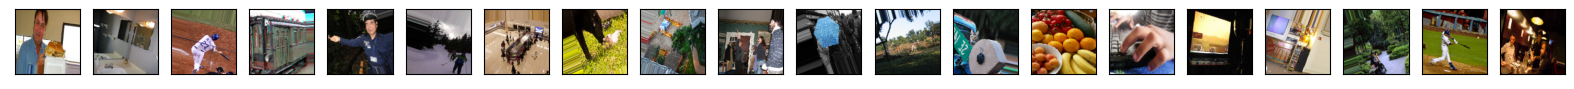

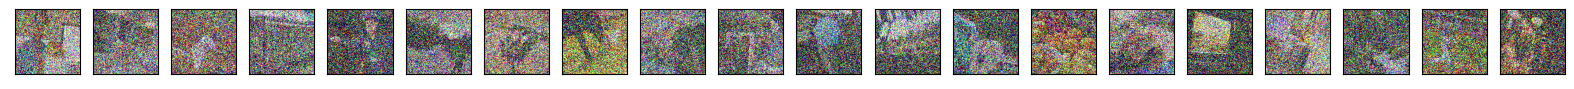

In [709]:
print("Train set")
show_noisy_images(train_generator)
print("Validation set")
show_noisy_images(validation_generator)

Ce code définit une fonction model qui construit un modèle de réseau de neurones appelé "autoencodeur".

Un autoencodeur est un type de modèle de réseau de neurones qui est utilisé pour l'apprentissage non supervisé. Il est formé de deux parties: un "encodeur" qui transforme les données d'entrée en une représentation compacte (appelée "code latent"), et un "décodeur" qui prend ce code latent en entrée et reconstruit une approximation des données d'entrée. L'objectif de l'apprentissage est de minimiser la différence entre les données d'entrée et la reconstruction produite par le décodeur.

La fonction model prend en entrée une forme d'image iput_shape et renvoie un modèle de réseau de neurones qui prend des images en entrée et les transforme en images reconstruites. Le modèle utilise des couches de convolution et de mise à l'échelle pour extraire des caractéristiques des images d'entrée et les reconstruire. Les couches de convolution utilisent une fonction d'activation ReLU pour introduire de la non-linéarité dans le modèle, tandis que la dernière couche utilise une fonction d'activation sigmoïde pour générer des prédictions de pixel compris entre 0 et 1.

Enfin, la fonction crée un objet Model de Keras à partir des entrées et des sorties du modèle et le retourne.

Après l'exécution de cette ligne de code, le modèle autoencoder est un objet Model de Keras qui peut être utilisé pour entraîner et évaluer le modèle en utilisant les fonctions de Keras telles que compile, fit et evaluate.

In [710]:
# def model(iput_shape):
#     input = Input(shape=iput_shape)

#     # encoding architecture
#     x1 = Conv2D(64, (3, 3), activation='relu', padding='same',
#                 kernel_regularizer=regularizers.l1(10e-10))(input)
#     x2 = Conv2D(64, (3, 3), activation='relu', padding='same',
#                 kernel_regularizer=regularizers.l1(10e-10))(x1)
#     x3 = MaxPool2D(padding='same')(x2)
#     x4 = Conv2D(128, (3, 3), activation='relu', padding='same',
#                 kernel_regularizer=regularizers.l1(10e-10))(x3)
#     x5 = Conv2D(128, (3, 3), activation='relu', padding='same',
#                 kernel_regularizer=regularizers.l1(10e-10))(x4)
#     x6 = MaxPool2D(padding='same')(x5)


#     encoded = Conv2D(256, (3, 3), activation='relu', padding='same',
#                     kernel_regularizer=regularizers.l1(10e-10))(x6)

#     # decoding architecture
#     x7 = UpSampling2D()(encoded)
#     x8 = Conv2D(128, (3, 3), activation='relu', padding='same',
#                 kernel_regularizer=regularizers.l1(10e-10))(x7)
#     x9 = Conv2D(128, (3, 3), activation='relu', padding='same',
#                 kernel_regularizer=regularizers.l1(10e-10))(x8)
#     x10 = Add()([x5, x9])
#     x11 = UpSampling2D()(x10)
#     x12 = Conv2D(64, (3, 3), activation='relu', padding='same',
#                 kernel_regularizer=regularizers.l1(10e-10))(x11)
#     x13 = Conv2D(64, (3, 3), activation='relu', padding='same',
#                 kernel_regularizer=regularizers.l1(10e-10))(x12)
#     x14 = Add()([x2, x13])

#     decoded = Conv2D(3, (3, 3), padding='same', activation='relu',
#                     kernel_regularizer=regularizers.l1(10e-10))(x14)

#     return keras.Model(input, decoded)

# autoencoder = model(iput_shape=(IMG_H, IMG_W, 3))


In [ ]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            Input(shape=(IMG_H, IMG_W, 3)),
            Conv2D(16, (3, 3), activation='relu', padding='same', stides=2),
            Conv2D(8, (3, 3), activation='relu', padding='same', stides=2),
        ])

        self.decoder = tf.keras.Sequential([
            Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

Cette ligne de code compile le modèle autoencoder en préparation pour l'entraînement.

La fonction compile de Keras prend plusieurs arguments qui spécifient comment le modèle doit être entraîné:

- optimizer: l'optimiseur utilisé pour mettre à jour les poids du modèle pendant l'entraînement. Dans ce cas, l'optimiseur Adam est utilisé avec un taux d'apprentissage spécifié par la variable LEARING_RATE.
- loss: la fonction de perte utilisée pour évaluer la performance du modèle pendant l'entraînement. Dans ce cas, la fonction de perte quadratique moyenne (MSE) est utilisée.
- metrics: une liste de métriques utilisées pour évaluer la performance du modèle pendant l'entraînement et la validation. Dans ce cas, seule la MSE est utilisée comme métrique.

Après la compilation du modèle, celui-ci est prêt à être entraîné en utilisant la fonction fit de Keras.

In [711]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARING_RATE),
    loss=tf.keras.losses.MeanSquaredError(),
    # metrics=[tf.keras.metrics.MeanSquaredError()]
)


Cette ligne de code utilise la fonction plot_model de keras.utils pour générer un diagramme de l'architecture du modèle autoencoder.

La fonction plot_model prend plusieurs arguments pour contrôler la génération du diagramme:

- autoencoder: le modèle à afficher.
- to_file: le nom de fichier où enregistrer le diagramme.
- show_shapes: un booléen qui indique si les formes des couches du modèle doivent être affichées.
- show_dtype: un booléen qui indique si le type de données des couches du modèle doivent être affichées.
- show_layer_names: un booléen qui indique si les noms des couches du modèle doivent être affichés.
- rankdir: la direction dans laquelle le diagramme doit être tracé ('TB' signifie "de haut en bas").
- expand_nested: un booléen qui indique si les couches imbriquées doivent être développées dans le diagramme.
- dpi: la résolution du diagramme en points par pouce.
- show_layer_activations: un booléen qui indique si les fonctions d'activation des couches du modèle doivent être affichées.

Après l'exécution de cette ligne de code, un fichier PNG contenant le diagramme du modèle sera enregistré à l'emplacement spécifié par la variable schema_file.

In [712]:
schema_file = "architecture/autoencoder_CNNV3.png"
keras.utils.plot_model(
    autoencoder,
    to_file=schema_file,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    show_layer_activations=True
    ),


(<IPython.core.display.Image object>,)

Cette ligne de code utilise la fonction summary de keras.Model pour afficher un résumé du modèle autoencoder.

Le résumé du modèle inclut les informations suivantes:

- Le nombre de couches du modèle, ainsi que leur type et leur forme.
- Le nombre de paramètres du modèle et le nombre de paramètres entraînables.
- Les formes d'entrée et de sortie du modèle.


Le résumé du modèle peut être utile pour comprendre l'architecture du modèle et son niveau de complexité.

In [713]:
autoencoder.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_212 (Conv2D)            (None, 128, 128, 64  1792        ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_213 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_212[0][0]']             
                                )                                                          

- La variable models_dir contient le chemin complet du fichier de sauvegarde du modèle, qui comprend le nom de fichier "model_autoencoder.h5" et une date et une heure en tant que répertoire de sauvegarde.

- La variable logs_dir contient le chemin d'un répertoire où les journaux de l'entraînement seront enregistrés. Le nom du répertoire comprend également une date et une heure.


Les deux variables sont basées sur la date et l'heure actuelles, ce qui permet de créer des emplacements de sauvegarde uniques pour chaque exécution du code.


In [714]:
# Definition de la validation croisée
models_dir = 'models/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/' + 'model_autoencoder.h5'
logs_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Cette ligne de code crée une liste de "callbacks" de Keras qui seront utilisés pendant l'entraînement du modèle.

Les callbacks de Keras sont des objets qui peuvent être utilisés pour effectuer des actions pendant l'entraînement du modèle, comme enregistrer des journaux, enregistrer les poids du modèle, ou interrompre l'entraînement si certaines conditions sont remplies.

Dans ce cas, trois callbacks sont créés:

- TensorBoard: enregistre des journaux de l'entraînement dans un répertoire spécifié par la variable logs_dir, de sorte qu'ils puissent être visualisés dans TensorBoard.

- ModelCheckpoint: enregistre les poids du modèle pendant l'entraînement dans un fichier spécifié par la variable models_dir, en enregistrant uniquement les meilleurs poids selon la perte de validation.

- EarlyStopping: interrompt l'entraînement si la perte de validation n'a pas diminué pendant un certain nombre d'époques (spécifié par la variable patience).

Les callbacks seront passés à la fonction fit de Keras lors de l'entraînement du modèle afin qu'ils puissent être utilisés pour effectuer leurs actions pendant l'entraînement.

In [715]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logs_dir , histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(models_dir, verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto') , 
]

Cette ligne de code utilise la fonction fit de keras.Model pour entraîner le modèle autoencoder sur les données générées par les générateurs train_generator et validation_generator.

La fonction fit prend plusieurs arguments pour contrôler l'entraînement du modèle:

- train_generator: le générateur de données d'entraînement.
- steps_per_epoch: le nombre de pas (c'est-à-dire, de lots) à utiliser pour chaque époque.
- epochs: le nombre d'époques à utiliser pour entraîner le modèle.
- validation_data: le générateur de données de validation.
- validation_steps: le nombre de pas à utiliser pour valider le modèle à chaque fin d'époque.
- callbacks: une liste de callbacks de Keras à utiliser pendant l'entraînement.
- verbose: un entier qui contrôle la quantité d'informations affichées pendant l'entraînement.

La fonction fit retourne un objet History qui contient les informations de l'entraînement du modèle, comme les pertes et les métriques d'entraînement et de validation à chaque époque. Cet objet est enregistré dans la variable hist.

In [716]:
hist = autoencoder.fit(
    train_generator,
    # steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    # validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.4608
Epoch 1: val_loss improved from inf to 0.04868, saving model to models/20230116-234832\model_autoencoder.h5
250/250 [==============================] - 87s 346ms/step - loss: 0.0658 - accuracy: 0.4608 - val_loss: 0.0487 - val_accuracy: 0.5219
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.5311
Epoch 2: val_loss did not improve from 0.04868
250/250 [==============================] - 86s 342ms/step - loss: 0.0593 - accuracy: 0.5311 - val_loss: 0.0521 - val_accuracy: 0.5694
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.5520
Epoch 3: val_loss did not improve from 0.04868
250/250 [==============================] - 86s 346ms/step - loss: 0.0484 - accuracy: 0.5520 - val_loss: 0.0539 - val_accuracy: 0.5655
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.5662
Epoch 4: val

Cette ligne de code accède à l'objet history de l'objet History retourné par la fonction fit, puis utilise la méthode keys de l'objet history pour obtenir une liste des clés de l'objet history.

L'objet history est un dictionnaire Python qui contient les informations de l'entraînement du modèle, comme les pertes et les métriques d'entraînement et de validation à chaque époque. Les clés du dictionnaire sont les noms des informations de l'entraînement, tels que "loss" (pour la perte d'entraînement), "val_loss" (pour la perte de validation), "mean_squared_error" (pour la métrique "mean squared error" d'entraînement), etc.

En appelant la méthode keys, vous obtenez une liste de toutes les clés de l'objet history, ce qui vous permet de savoir quelles informations de l'entraînement sont disponibles dans l'objet history.

In [724]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Cette ligne de code utilise la fonction plot de matplotlib pour tracer les pertes d'entraînement et de validation à chaque époque.

La fonction plot prend plusieurs arguments:

- hist.history['loss']: une liste des pertes d'entraînement à chaque époque.
- hist.history['val_loss']: une liste des pertes de validation à chaque époque.
- title: le titre du graphique.
- ylabel: l'étiquette de l'axe des y.
- xlabel: l'étiquette de l'axe des x.
- legend: une légende pour les différentes séries de données du graphique.
- loc: l'emplacement de la légende sur le graphique.


Le résultat est un graphique qui affiche les pertes d'entraînement et de validation à chaque époque. Cela peut vous aider à voir comment la perte a évolué pendant l'entraînement et à identifier éventuellement des problèmes tels que surajustement ou sous-ajustement.

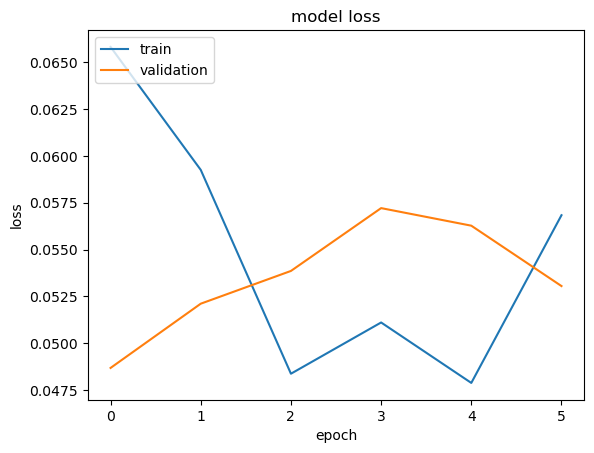

In [725]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Les fonctions denoise_images_from_dataset et denoise_images_from_file affichent ensuite l'image bruyante et l'image débruitée prédite côte à côte pour vous permettre de comparer les deux images. Cela peut vous aider à évaluer la performance de votre modèle de débruitage et à déterminer s'il est efficace pour enlever le bruit des images.





In [721]:
def denoise_images_from_dataset(dataset , autoencoder):
    noisy_img , label = next(dataset)
    denoised_img = autoencoder.predict(noisy_img)
    print("Noisy image :")
    show_images(noisy_img, 5)
    print("Denoised image :")
    show_images(denoised_img, 5)

def denoise_images_from_file(file_path):
    noisy_img = keras.preprocessing.image.load_img(file_path, target_size=(IMG_H, IMG_W))
    noisy_img = keras.preprocessing.image.img_to_array(noisy_img)
    noisy_img = noisy_img * RESCALING_FACTOR
    noisy_img = tf.expand_dims(noisy_img, 0)

    denoised_img = autoencoder.predict(noisy_img)
    
    print("Noisy image :")
    show_images(noisy_img, 1)
    print("Denoised image :")
    show_images(denoised_img, 1)

La fonction denoise_images_from_dataset prend en entrée un générateur de données et utilise la méthode predict de keras.Model pour prédire des images débruitées pour un lot de données bruyant.


1/1 [==============================] - 0s 94ms/step
Noisy image :


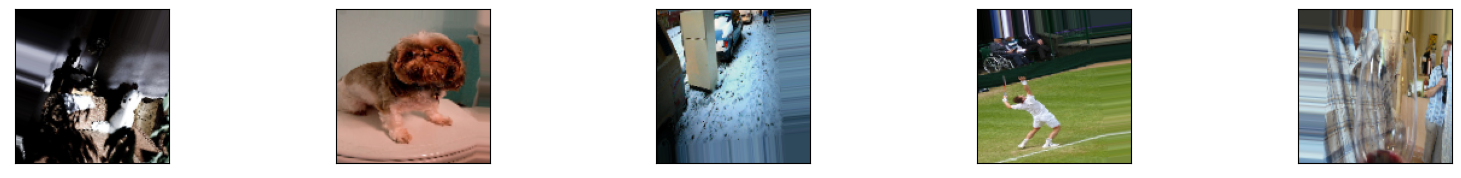

Denoised image :


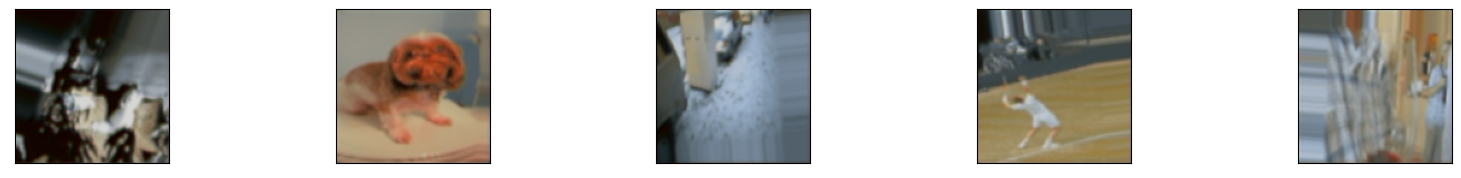

In [722]:
denoise_images_from_dataset(test_generator , autoencoder)

La fonction denoise_images_from_file prend en entrée un chemin de fichier et utilise la fonction load_img de keras.preprocessing.image pour charger l'image bruyante à partir du disque. L'image est ensuite convertie en tableau à l'aide de la fonction img_to_array et prétraitée en fonction des hyperparamètres du modèle. Enfin, la méthode predict de keras.Model est utilisée pour prédire une image débruitée pour l'image bruyante.


1/1 [==============================] - 0s 104ms/step
Noisy image :


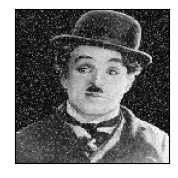

Denoised image :


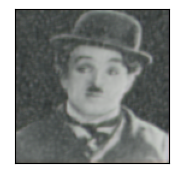

In [723]:
image_path = "test/noisy_google_02.jpg"
denoise_images_from_file(image_path)

Cette ligne de code utilise la méthode save de keras.Model pour enregistrer le modèle autoencoder sur le disque.

La méthode save prend un argument, qui est le chemin de fichier où le modèle doit être enregistré. Le modèle est enregistré sous forme de fichier HDF5, qui peut être chargé plus tard à l'aide de la fonction load_model de keras.models.

En enregistrant le modèle, vous pouvez le charger plus tard pour le réutiliser ou le déployer dans un environnement de production. Cela peut être particulièrement utile si vous avez entraîné un modèle pendant de nombreuses heures et que vous ne voulez pas avoir à recommencer l'entraînement à partir de zéro chaque fois que vous en avez besoin.





In [719]:
autoencoder_model_dir = "models_best_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_model_autoencoder_v3.h5' 
autoencoder.save(autoencoder_model_dir)

Cette ligne de code utilise la fonction load_model de keras.models pour charger le modèle enregistré précédemment à partir du disque.

La fonction load_model prend un argument, qui est le chemin du fichier où le modèle a été enregistré. Elle renvoie un objet Model qui est une instance du modèle enregistré.

Ensuite, le modèle est évalué sur le jeu de données de validation en utilisant la méthode evaluate de keras.Model. La méthode evaluate prend les arguments suivants:

- validation_generator: le générateur de données de validation à utiliser pour évaluer le modèle.
- batch_size: la taille du lot à utiliser pour l'évaluation.
- steps: le nombre de lots à utiliser pour l'évaluation.

La méthode evaluate renvoie un tuple avec les pertes et les métriques du modèle sur le jeu de données de validation. Cela peut vous aider à évaluer la performance du modèle et à déterminer si le modèle est prêt à être déployé dans un environnement de production.





In [720]:
# lts_model_dir="models_best_fit/20230116-184512_model_autoencoder.h5"

best_model_autoencoder = keras.models.load_model(autoencoder_model_dir)
# Evaluation du modèle
best_model_autoencoder.evaluate(
    validation_generator, batch_size=BATCH_SIZE, steps=VALIDATION_STEPS)


62/62 [==============================] - 16s 260ms/step - loss: 0.0462 - accuracy: 0.5608


[0.04615228250622749, 0.5608484745025635]